# 13-19 Aprile 2022: analisi dati completa per presentazione lavoro

In [35]:

import tempfile
import sys
import os

import ROOT

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from uncertainties import ufloat, umath

from ROOT import TH1D, TF1, TGraphErrors, TCanvas



In [36]:
%jsroot on
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
ROOT.gInterpreter.AddIncludePath('/usr/local/include')
ROOT.gSystem.Load('/usr/local/lib/libErrorAnalysis')
ROOT.gSystem.Load('/usr/local/lib/libLabTools')


0

In [4]:
ROOT.gInterpreter.ProcessLine('''#include<LabPlot.h>
#include<LabStat.h>''')

ROOT.set_atlas_style(28)

Applying ATLAS style settings


## Analogico: analisi dati finale

Problemi: incompatibilità con il valore teorico di $v_s$, osservare che per questi dati non abbiamo valutato la media ma solo il valore del primo fronte dell'onda, potrebbe essere sbagliato (anche considerato che utilizzando invece i dati della presa dati digitale otteniamo forse un valore più vicino alla teoria?)


### Fit: quale funzione vogliamo utilizzare?

Abbiamo effettuato il fit considerando una funzione lineare, per cui (ipotizzando che ricevitore ed emettitore siano in asse abbiamo che $d = v_s\cdot t.$ Dobbiamo però considerare la possibilità di un errore sistematico di offset sulla distanza $d$, quindi rendendo la funzione di fit simile a $d=d_\text{offset}+v_st.$

Però abbiamo che potremmo non avere in perfetto asse i due strumenti e quindi la necessità di avere un offset laterale, per cui la distanza che in realtà compie è $d_\text{true}=\sqrt{d_\text{meas} + \delta_\text{lat}}.$ Così facendo abbiamo che però non funziona il fit per il secondo set di dati, mentre con il primo abbiamo un miglior rendimento (Prob($\chi^2$) > 70%). Inoltre in tale modo i rusultati non vengono compatibili.

Funzione con approssimazione ad ordime maggiore sarebbe quindi $$d=\sqrt{v_s^2t^2 + \text{(offset)}^2 -\delta^2 + 2\text{(offset)}v_st},$$ oppure $$t = \frac{1}{v_s}\sqrt{d^2+\delta^2}+\frac{\text{offset}}{v_s}.$$

In [5]:

path_misc = '../misc'
path_data = '../dati'

analogic_files = ['uedge_analog_data_220329.txt',
                  'dedge_analog_data_220329.txt']

def get_t_range_error(range1, errPercent=0.0016, partitions=10.0):
    return range1 * errPercent * partitions / np.sqrt(3);

offset_tmp = 0.19; # offset di misura (initial guess)
diametro_spk = 0.05985; # 2*offset verticale (da aggiungere in quadratura)



In [6]:
def setup_data(filename, color, function = '[0]+[1]*x', name = 'analog_rise'):
    graph = TGraphErrors()
    graph.SetTitle(';Delay [ms];Distance + bias [m]')
    fit = TF1(name, function)
    
    graph.SetLineColor(color)
    graph.SetMarkerColor(color)
    fit.SetLineColor(color)
    
    file = open(os.path.join(path_data, filename))
    lines = file.readlines()
    for idx, line in enumerate(lines):
        data = line.split()
        graph.SetPoint(idx, float(data[1]), float(data[0]))
        graph.SetPointError(idx, get_t_range_error(float(data[2])), 0.002/np.sqrt(3))
    
    return graph, fit
    

In [7]:
rise_analogic, f_rise_analogic = setup_data(analogic_files[0], ROOT.kBlack, name='analog_rise')
fall_analogic, f_fall_analogic = setup_data(analogic_files[1], ROOT.kRed, name='analog_fall')

 FCN=5.85456 FROM MIGRAD    STATUS=CONVERGED      56 CALLS          57 TOTAL
                     EDM=9.34562e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.46874e-01   8.02991e-04   4.41365e-07   1.31602e+00
   2  p1           3.47770e-01   1.16103e-03   6.38171e-07   1.93238e+00
 FCN=0.451031 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=1.02157e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.27966e-01   1.45501e-03   2.83078e-07  -2.57147e-01
   2  p1           3.49848e-01   1.65020e-03   3.21052e-07  -2.57306e-01


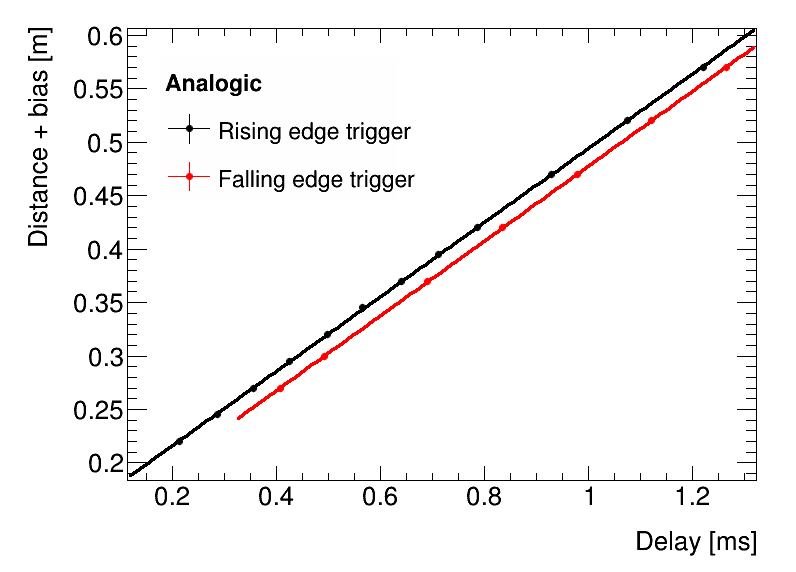

In [8]:
%jsroot off


c1 = TCanvas('c1', '', 800, 600)
l = ROOT.TLegend(0.2, 0.65, 0.5, 0.9)
l.SetFillColorAlpha(0, 0.75)
l.SetTextSize(25)
l.SetHeader('#bf{Analogic} #it{}')


rise_analogic.Draw('ap')
rise_analogic.Fit('analog_rise')
fall_analogic.Draw('p')
fall_analogic.Fit('analog_fall')
l.AddEntry(rise_analogic, 'Rising edge trigger', 'LPE')
l.AddEntry(fall_analogic, 'Falling edge trigger', 'LPE')
l.Draw()
c1.Draw()

In [9]:
def print_results2par(f_rise, f_fall, name='analogic'):
    
    popt_rise, poperr_rise = f_rise.GetParameters(), f_rise.GetParErrors()
    popt_fall, poperr_fall = f_fall.GetParameters(), f_fall.GetParErrors()
    
    sspeed_rise = ufloat(popt_rise[1], poperr_rise[1])
    sspeed_fall = ufloat(popt_fall[1], poperr_fall[1])
    
    offset_rise = ufloat(popt_rise[0], poperr_rise[0])
    offset_fall = ufloat(popt_fall[0], poperr_fall[0])
    
    print('rise ({}):\t{:.3uS} m/s\t[offset: {:.3uS} m]'.format(name, sspeed_rise*1000, offset_rise))
    print('fall ({}):\t{:.3uS} m/s\t[offset: {:.3uS} m]'.format(name, sspeed_fall*1000, offset_fall))
    
    print(' * compatibilità sspeed_ag: {}'.format(ROOT.LabStat.compatible_nocorr(popt_rise[1], poperr_rise[1], popt_fall[1], poperr_fall[1])))
    print(f' ** {ROOT.LabStat.get_statsign(popt_rise[1], poperr_rise[1], popt_fall[1], poperr_fall[1])}')
    print(' * compatibilità offsets:   {}'.format(ROOT.LabStat.compatible_nocorr(popt_rise[0], poperr_rise[0], popt_fall[0], poperr_fall[0])))
    
    
    sspeed = ROOT.LabStat.getbestvalue(popt_rise[1], poperr_rise[1], popt_fall[1], poperr_fall[1])
    sspeed_err = ROOT.LabStat.getbestvalueerr(poperr_rise[1], poperr_fall[1])
    
    print('rise+fall ({}):\t{:.3uS} m/s'.format(name, ufloat(sspeed, sspeed_err)*1000))
    
    return sspeed*1000, sspeed_err*1000



In [10]:
print_results2par(f_rise_analogic, f_fall_analogic)
c1.Print('../fig/plot_analog_220417.pdf')

rise (analogic):	347.77(1.16) m/s	[offset: 0.146874(803) m]
fall (analogic):	349.85(1.65) m/s	[offset: 0.12797(146) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.030072 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  11.377244 σ
rise+fall (analogic):	348.458(950) m/s


Info in <TCanvas::Print>: pdf file ../fig/plot_analog_220417.pdf has been created


In [11]:
ROOT.gInterpreter.ProcessLine('''
#include<LabTools.h>
''')

0

In [12]:
ROOT.logs.print_stat(f_rise_analogic), ROOT.logs.print_stat(f_fall_analogic)

(None, None)


** CHI2 / NDF ( PROB. ) 5.85456 / 10 ( 0.827331 )


** CHI2 / NDF ( PROB. ) 0.451031 / 5 ( 0.993807 )



## Digitale: analisi dati finale

In [28]:
def histo4plot(filename):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(12.5, 2.5))
    ax1.set_ylabel('Entries ({})'.format(filename[:14]))
    ax1.set_xlabel('RISE_event $t_1$ [$\mu$s]')
    ax2.set_xlabel('RISE_event $t_2$ [$\mu$s]')
    ax3.set_xlabel('FALL_event $t_1$ [$\mu$s]')
    ax4.set_xlabel('FALL_event $t_2$ [$\mu$s]')
    fNdataread = 50
    timeRUN_onrise = np.zeros((2, fNdataread))
    timeRUN_onfall = np.zeros((2, fNdataread))
    
    file = open(os.path.join(path_misc, filename))
    
    for j in range(2):
        for i in range(50):
            data = file.readline()
            timeRUN_onrise[j][i] = float(data)
    
    for j in range(2):
        for i in range(50):
            data = file.readline()
            timeRUN_onfall[j][i] = float(data)
    
    ax3.hist(timeRUN_onfall[0], bins=20)
    ax4.hist(timeRUN_onfall[1], bins=20)
    ax1.hist(timeRUN_onrise[0], bins=20)
    ax2.hist(timeRUN_onrise[1], bins=20)
    if filename == 'DATA_serial_25.txt' or filename == 'DATA_serial_50.txt':
        fig.savefig('../fig/histo{}.pdf'.format(filename[12:14]), bbox_inches='tight')

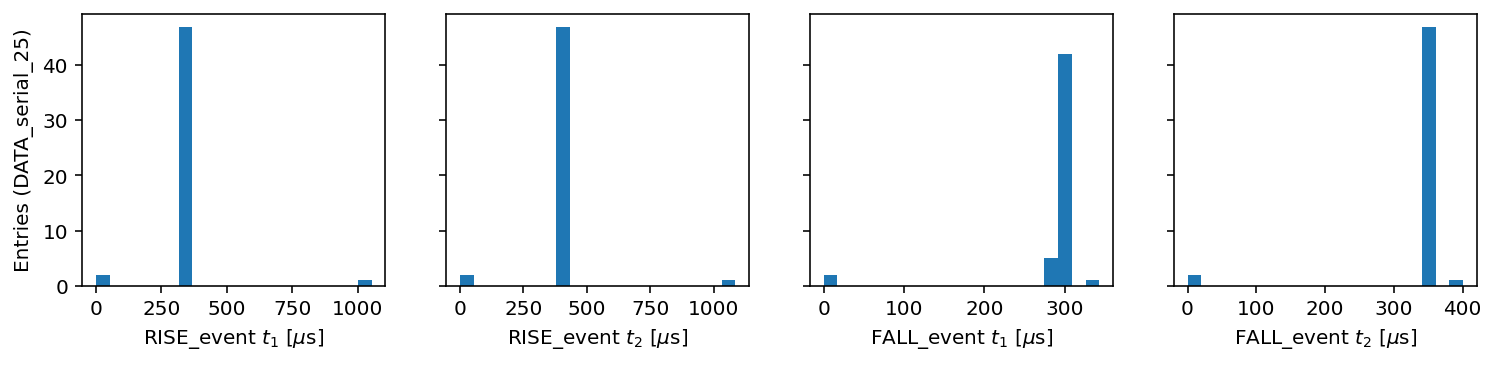

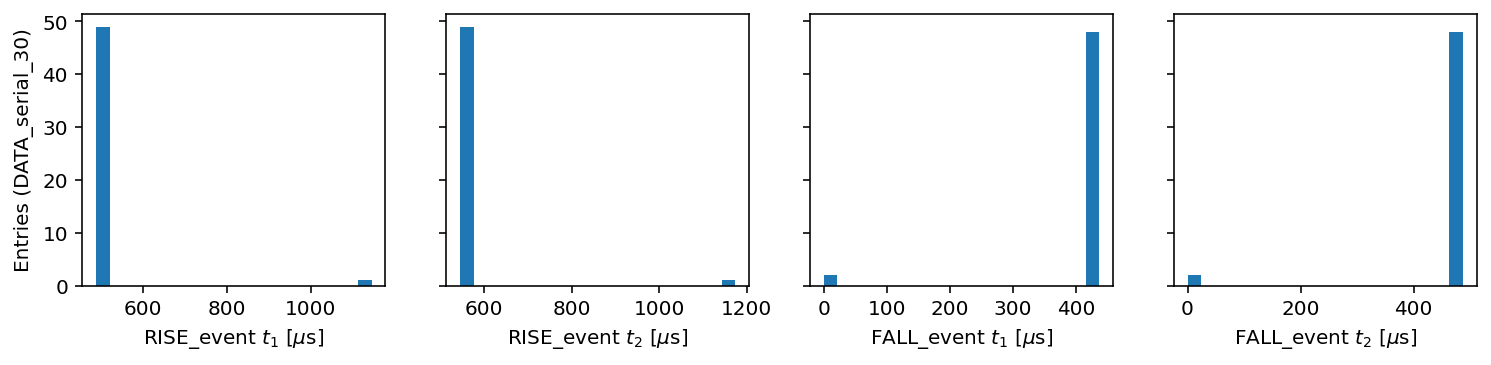

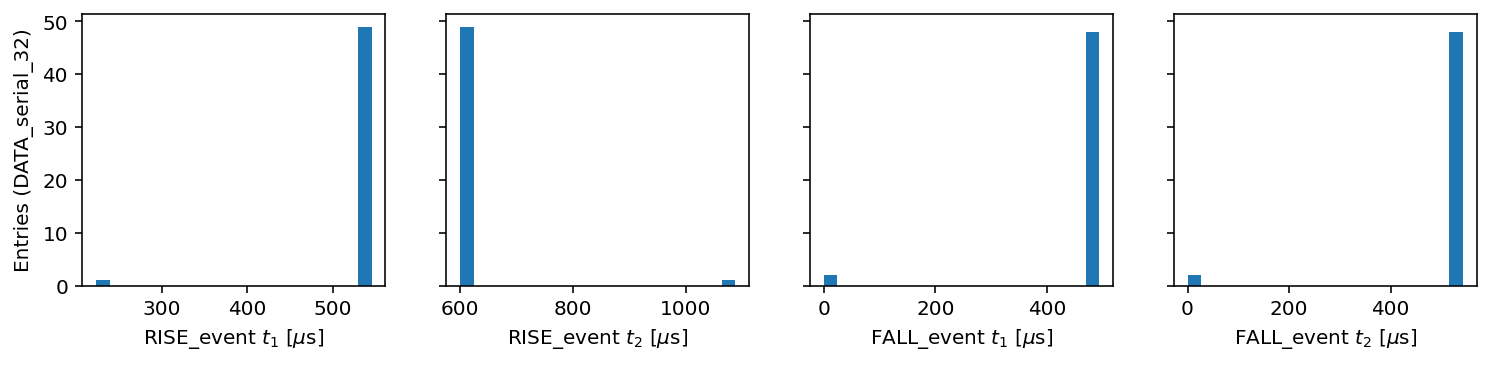

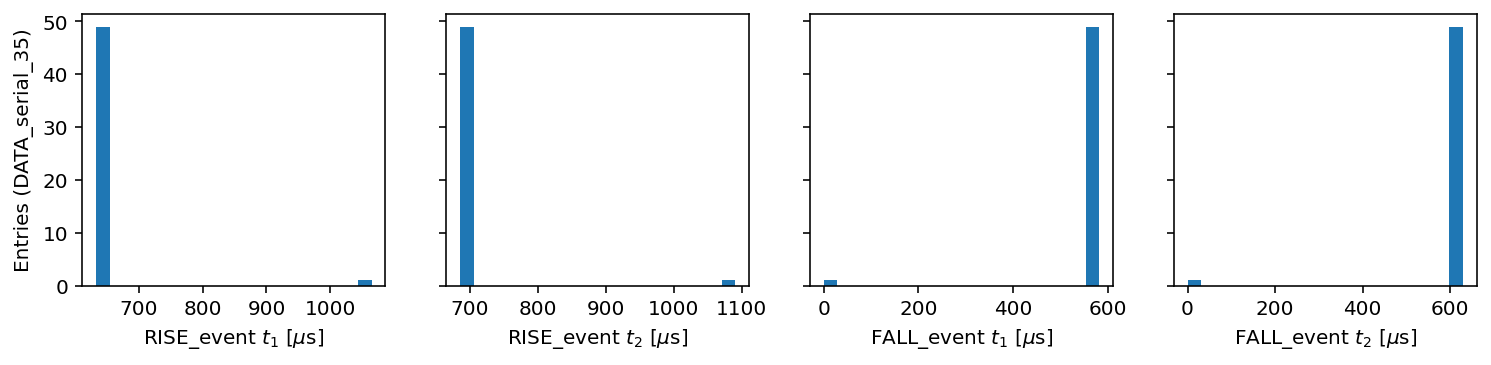

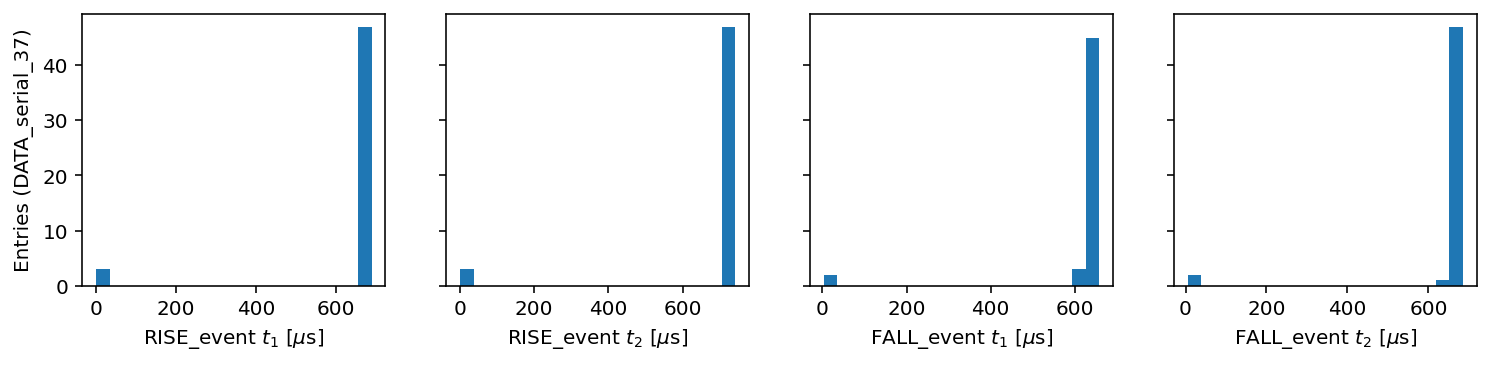

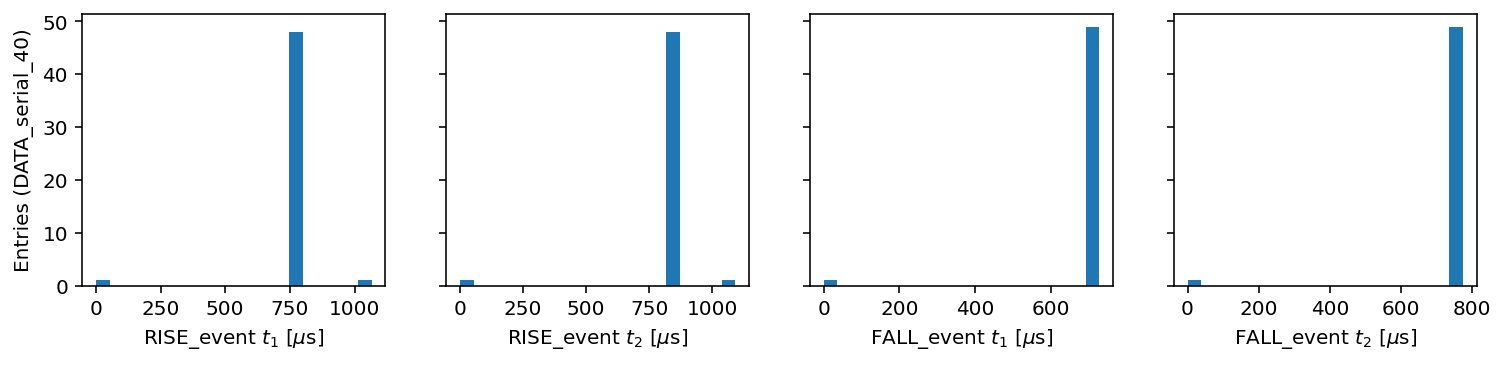

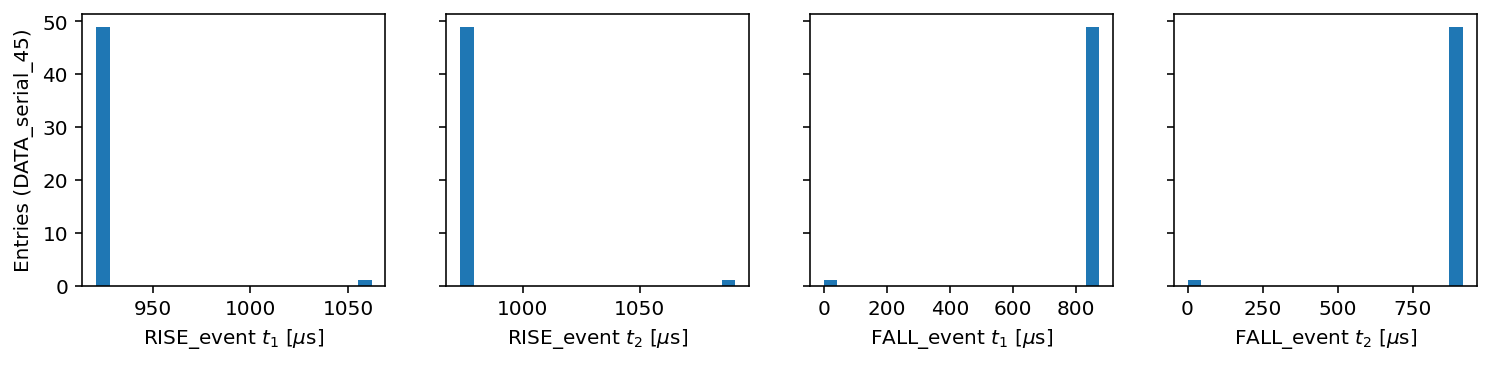

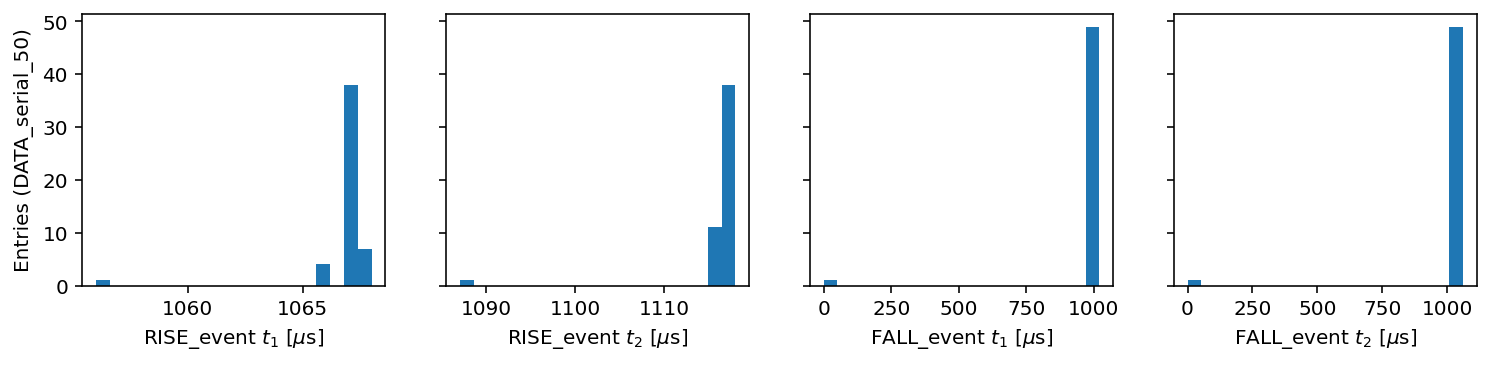

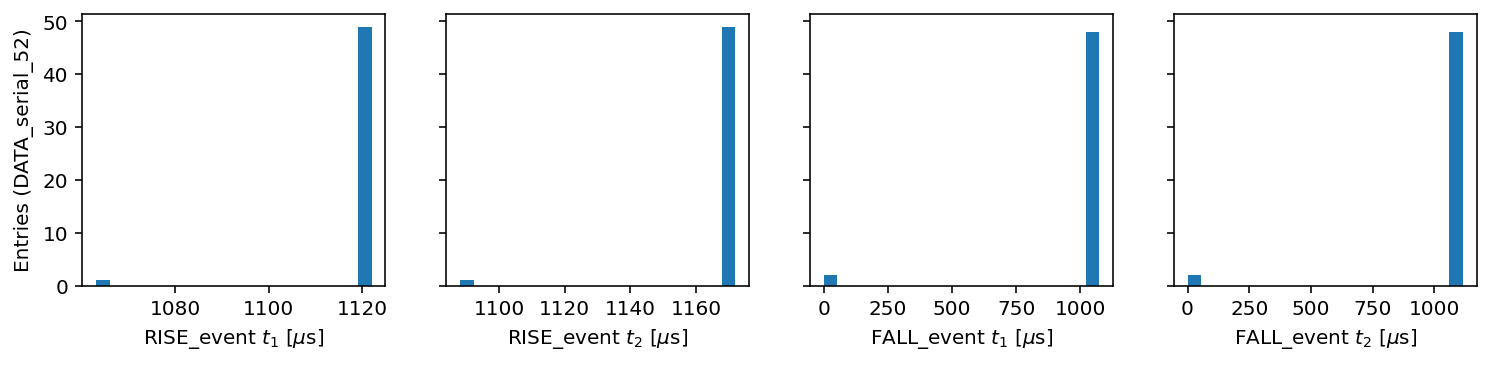

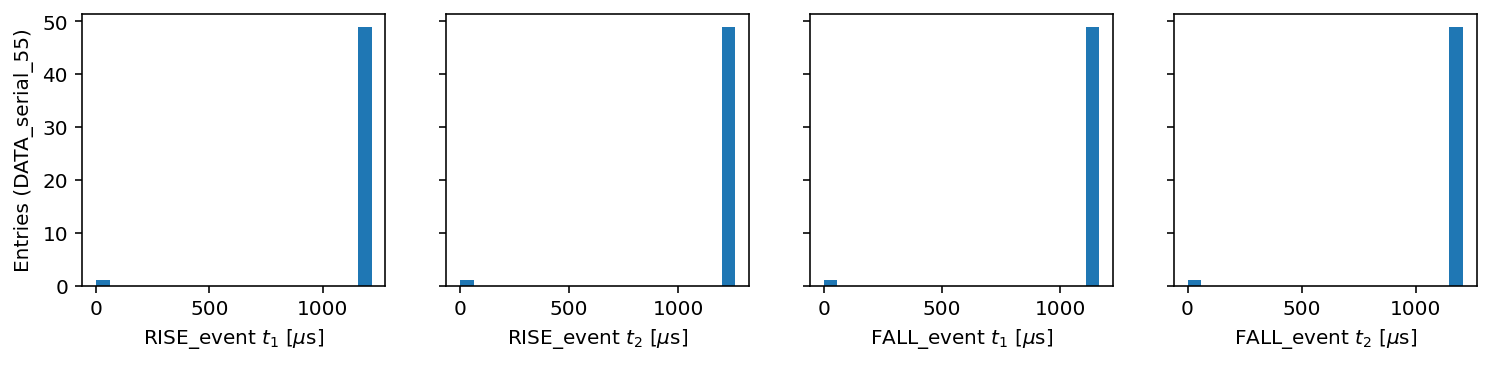

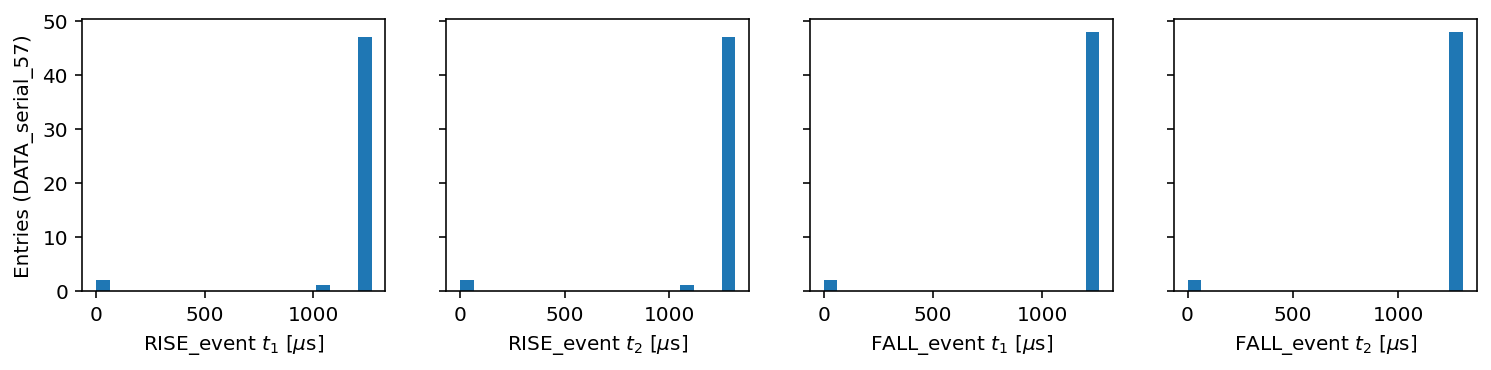

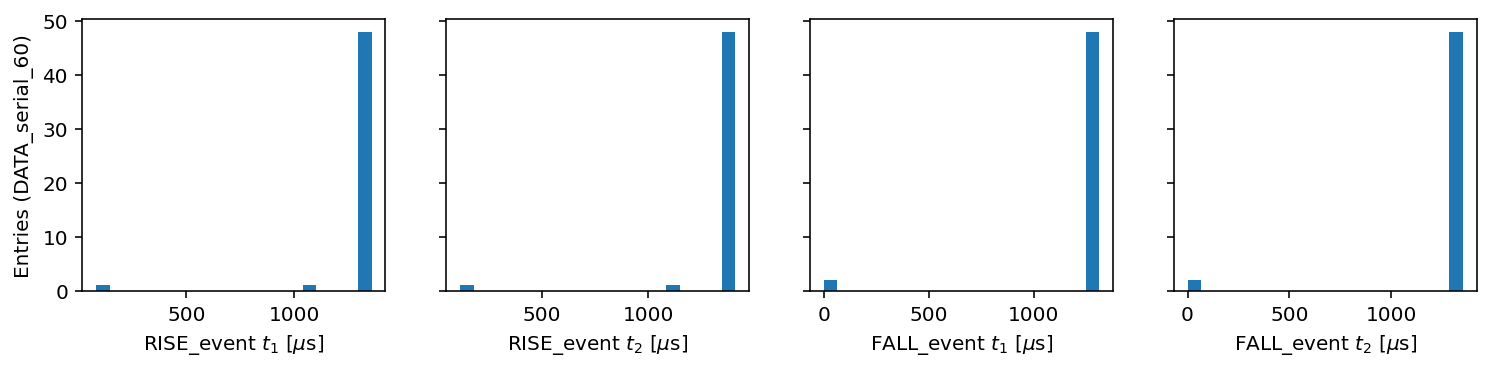

In [31]:

digital_files = ['DATA_serial_25.txt',
                 'DATA_serial_30.txt',
                 'DATA_serial_32.txt',
                 'DATA_serial_35.txt',
                 'DATA_serial_37.txt',
                 'DATA_serial_40.txt',
                 'DATA_serial_45.txt',
                 'DATA_serial_50.txt',
                 'DATA_serial_52.txt',
                 'DATA_serial_55.txt',
                 'DATA_serial_57.txt',
                 'DATA_serial_60.txt']


for idx, file in enumerate(digital_files):
    histo4plot(file)

In [32]:
from numpy import array, sqrt, float32

def discriminate_outliers(data_input: list, outliers=[0]) -> list:
    
    value = data_input
    
    for outlier in outliers:
        value = list(filter(lambda point: point != outlier, value))
        
    return value

In [33]:

def get_times(filename, o1=[0], o2=[0], o3=[0], o4=[0]):
    
    t_rise,err_t_rise = 0,0
    t_fall,err_t_fall = 0,0
    
    with open(os.path.join(path_misc, filename)) as file:
        df = file.readlines();
        
        avg_rise_t1 = array(discriminate_outliers(array(df[:50], dtype=float32).tolist(), outliers=o1)).mean()
        avg_rise_t2 = array(discriminate_outliers(array(df[51:100], dtype=float32).tolist(), outliers=o2)).mean()
        avg_fall_t1 = array(discriminate_outliers(array(df[101:150], dtype=float32).tolist(), outliers=o3)).mean()
        avg_fall_t2 = array(discriminate_outliers(array(df[151:], dtype=float32).tolist(), outliers=o4)).mean()
        
        err_rise_t1 = array(discriminate_outliers(array(df[:50], dtype=float32).tolist(), outliers=o1)).std()
        err_rise_t2 = array(discriminate_outliers(array(df[51:100], dtype=float32).tolist(), outliers=o2)).std()
        err_fall_t1 = array(discriminate_outliers(array(df[101:150], dtype=float32).tolist(), outliers=o3)).std()
        err_fall_t2 = array(discriminate_outliers(array(df[151:], dtype=float32).tolist(), outliers=o4)).std()
        
        t_rise = array([avg_rise_t1, avg_rise_t2]).mean()
        err_t_rise = 0.5*sqrt(err_rise_t1**2 + err_rise_t2**2) if 0.5*sqrt(err_rise_t1**2 + err_rise_t2**2)>1 else 1
        
        t_fall = array([avg_fall_t1, avg_fall_t2]).mean()
        err_t_fall = 0.5*sqrt(err_fall_t1**2 + err_fall_t2**2) if 0.5*sqrt(err_fall_t1**2 + err_fall_t2**2)>1 else 1
    
    
    return ((t_rise/1000, err_t_rise/1000), (t_fall/1000, err_t_fall/1000))




In [34]:
dists = array([25, 30, 32, 35, 37, 40, 45, 50, 52, 55, 57, 60])/100

rise_t1_o1 = [[0, 1053], [1144], [223], [1065], [0], [0, 1065], [1062], [0], [0], [0], [0], [79]]             
rise_t2_o2 = [[0, 1085], [1174], [1088], [1091], [0], [0, 1092], [1091], [0], [0], [0], [0], [116]]
           
fall_t1_o3 = [[0], [0], [0], [0], [0, 3], [0], [0], [0], [0], [0], [0], [0]]            
fall_t2_o4 = [[0], [0], [0], [0], [0, 5], [0], [0], [0], [0], [0], [0], [0]]
              
# rise_delay = []
# err_rise_delay = []
# fall_delay = []
# err_fall_delay = []

# for files in digital_files:
#     ((rise_t, err_rise_t),(fall_t, err_fall_t)) = get_times(file)
#     rise_delay.append(rise_t)
#     err_rise_delay.append(err_rise_t)
#     fall_delay.append(fall_t)
#     err_fall_delay.append(err_fall_t)
    


In [51]:
rise_digital = TGraphErrors()
fall_digital = TGraphErrors()

rise_digital.SetTitle(';Delay [ms]; Distance + bias [m]')

fall_digital.SetLineColor(ROOT.kRed)
fall_digital.SetMarkerColor(ROOT.kRed)

for idx, d in enumerate(dists):
    ((rise_t, err_rise_t),(fall_t, err_fall_t)) = get_times(digital_files[idx], 
                                                            o1=rise_t1_o1[idx], 
                                                            o2=rise_t2_o2[idx], 
                                                            o3=fall_t1_o3[idx], 
                                                            o4=fall_t2_o4[idx])
    rise_digital.SetPoint(idx, rise_t, d)
    rise_digital.SetPointError(idx, err_rise_t, 0.002/sqrt(3))
    fall_digital.SetPoint(idx, fall_t, d)
    fall_digital.SetPointError(idx, err_fall_t, 0.002/sqrt(3))

In [52]:
fft = '[0]+[1]*x'

f_rise_digital = TF1('rise_digital', fft)
f_fall_digital = TF1('fall_digital', fft)

f_fall_digital.SetLineColor(ROOT.kRed)

 FCN=3.09403 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=4.37039e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.19780e-01   1.19837e-03   3.86350e-07   3.01764e-03
   2  p1           3.48481e-01   1.43165e-03   4.61560e-07   4.28111e-03
 FCN=2.73525 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=1.81866e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.40937e-01   1.14874e-03   3.59770e-07   5.00131e-02
   2  p1           3.45396e-01   1.25252e-03   3.92274e-07   4.36160e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


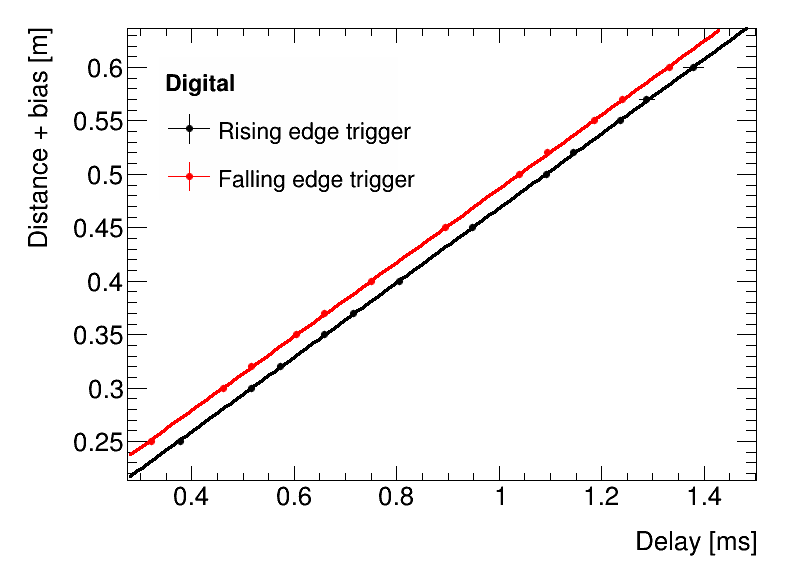

In [53]:
%jsroot off

c2 = TCanvas('c2', '', 800, 600)
l = ROOT.TLegend(0.2, 0.65, 0.5, 0.9)
l.SetFillColorAlpha(0, 0.75)
l.SetTextSize(25)
l.SetHeader('#bf{Digital} #it{}')

l.AddEntry(rise_digital, 'Rising edge trigger', 'LPE')
l.AddEntry(fall_digital, 'Falling edge trigger', 'LPE')

rise_digital.Draw('ap')
rise_digital.Fit('rise_digital')

fall_digital.Draw('p')
fall_digital.Fit('fall_digital')

l.Draw()
c2.Draw()

In [54]:
ROOT.logs.print_stat(f_rise_digital), ROOT.logs.print_stat(f_fall_digital)

(None, None)


** CHI2 / NDF ( PROB. ) 3.09403 / 10 ( 0.979124 )


** CHI2 / NDF ( PROB. ) 2.73525 / 10 ( 0.986986 )



In [55]:
print_results2par(f_rise=f_rise_digital, f_fall=f_fall_digital, name='digital')

rise (digital):	348.48(1.43) m/s	[offset: 0.11978(120) m]
fall (digital):	345.40(1.25) m/s	[offset: 0.14094(115) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.621698 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  12.744803 σ
rise+fall (digital):	346.733(943) m/s


(346.7332840646392, 0.9426765100821434)

In [56]:

c2.Print('../fig/plot_digital_220417.pdf')

Info in <TCanvas::Print>: pdf file ../fig/plot_digital_220417.pdf has been created


## Data compatibility and results



In [57]:
def get_statsignificance(v1, v2):
    return (v1[0] - v2[0])/np.sqrt(v1[1]**2 + v2[1]**2)


def plot_results(theory=500):
    sspeed_analogic, sspeed_analogic_err = print_results2par(f_rise=f_rise_analogic, f_fall=f_fall_analogic, name='analogic')
    print('\n')
    sspeed_digital, sspeed_digital_err = print_results2par(f_rise=f_rise_digital, f_fall=f_fall_digital, name='digital')
    
    
    sspeed_bv = ROOT.LabStat.getbestvalue(sspeed_digital, sspeed_digital_err, sspeed_analogic, sspeed_analogic_err)
    sspeed_bv_err = ROOT.LabStat.getbestvalueerr(sspeed_digital_err, sspeed_analogic_err)
    
    print('\n* compatibilità digitale/analogica: {}'.format(ROOT.LabStat.compatible_nocorr(sspeed_digital, sspeed_digital_err, 
                                                                                           sspeed_analogic, sspeed_analogic_err)))
    
    print('** {}'.format(ROOT.LabStat.get_statsign(sspeed_digital, sspeed_digital_err,
                                                   sspeed_analogic, sspeed_analogic_err)))
    
    values = [[theory[0], theory[1]],
              [sspeed_bv, sspeed_bv_err],
              [sspeed_digital, sspeed_digital_err],
              [sspeed_analogic, sspeed_analogic_err]]
    
    annotations = ['theory (temperature $T=20^\circ$C)',
                   'analogic + digital data',
                   'digital data',
                   'analogic data']
    
    colors = ['dodgerblue', 'red', 'orchid', 'mediumseagreen']
    colors.reverse()
    
    fig, ax = plt.subplots(figsize=(7,3.5))
    
    ax.set_yticklabels([])
    ax.tick_params(direction='out', bottom=True, top=False, left=False, right=False)
    ax.set_xlabel('deviation from theory  $v_s - {}$ [m/s]'.format(theory[0]))
    
    xposition = values[3][0]-theory[0]+1.5
    
    for idx, value in enumerate(values):
        ax.errorbar(x=(value[0]-theory[0]), y=idx, xerr=value[1], fmt='o', color=colors[idx], label=annotations[idx])
        ax.annotate(('$+{:.2}\sigma$, {}\n${:.2uSL}$ m/s'
                     .format(get_statsignificance(value, [theory[0], theory[1]]), 
                             annotations[idx], 
                             ufloat(value[0], value[1])) if idx != 0 
                     else '{}\n${:.2uSL}$ m/s'
                     .format(annotations[idx], ufloat(value[0], value[1]))),
                    (xposition, idx-0.05), annotation_clip=False)
    
    fig.subplots_adjust(right=0.65)
    ax.set_ybound(-0.45,len(values)-0.55)
    plt.axvspan(xmin=sspeed_bv-sspeed_bv_err-theory[0], xmax=sspeed_bv+sspeed_bv_err-theory[0], color='purple', alpha=0.25)
    plt.axvspan(xmin=-theory[1], xmax=theory[1], color=colors[0], alpha=0.25)
    plt.show()
    fig.savefig('../fig/results_data.pdf', bbox_inches='tight')
    
    print('E6/R3: sound_speed (initial bias: {:.3uS} m/s): {:.3uS} m/s'.format(ufloat(theory[0], theory[1]), ufloat(sspeed_bv, sspeed_bv_err)))
    return sspeed_bv, sspeed_bv_err
    



In [68]:

theory = 343.21
err_theory = (346.13-340.27)/(10*sqrt(3))

### Results for E6/R3

rise (analogic):	347.77(1.16) m/s	[offset: 0.146874(803) m]
fall (analogic):	349.85(1.65) m/s	[offset: 0.12797(146) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.030072 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  11.377244 σ
rise+fall (analogic):	348.458(950) m/s


rise (digital):	348.48(1.43) m/s	[offset: 0.11978(120) m]
fall (digital):	345.40(1.25) m/s	[offset: 0.14094(115) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.621698 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  12.744803 σ
rise+fall (digital):	346.733(943) m/s

* compatibilità digitale/analogica: COMPATIBILE
** significativita' statistica  1.289032 σ


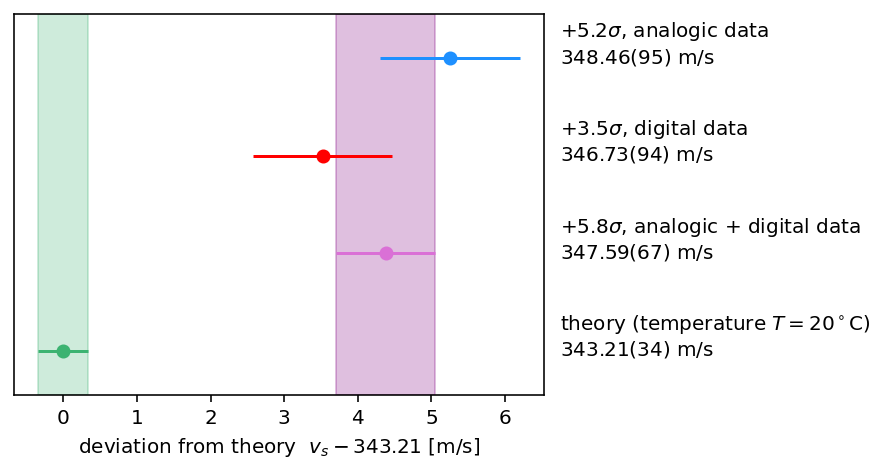

E6/R3: sound_speed (initial bias: 343.210(338) m/s): 347.589(669) m/s


(347.58938906184795, 0.6689915652494866)

In [69]:
## Results for E6/R3
##  - theroy = 343 m/s is the closest to reality
## 

plot_results(theory=(theory, err_theory))



In [65]:
err_theory=(349.02-343.21)/(10*sqrt(3))

rise (analogic):	347.77(1.16) m/s	[offset: 0.146874(803) m]
fall (analogic):	349.85(1.65) m/s	[offset: 0.12797(146) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.030072 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  11.377244 σ
rise+fall (analogic):	348.458(950) m/s


rise (digital):	348.48(1.43) m/s	[offset: 0.11978(120) m]
fall (digital):	345.40(1.25) m/s	[offset: 0.14094(115) m]
 * compatibilità sspeed_ag: COMPATIBILE
 ** significativita' statistica  1.621698 σ
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  12.744803 σ
rise+fall (digital):	346.733(943) m/s

* compatibilità digitale/analogica: COMPATIBILE
** significativita' statistica  1.289032 σ


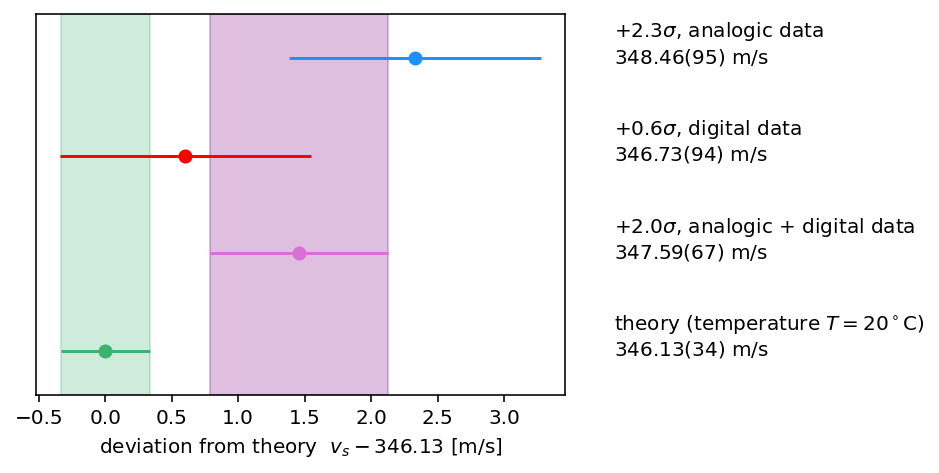

E6/R3: sound_speed (initial bias: 346.130(335) m/s): 347.589(669) m/s


(347.58938906184795, 0.6689915652494866)

In [66]:
plot_results(theory=(346.13, err_theory))

## Incompatibilità tra i valori ottenuti da E6/analogic ed E6/digital
troviamo che i valori sono ~incompatibili~ tra di loro, quindi non possiamo teoricamente valcolarne una miglior stima, che infatti non riporterei in relazione. Il motivo per l'incompatibilità è forse anche da cercare nella differente modalità di inferenza del dato, da una parte abbiamo considerato solo il primo fronte per identificare l'arrivo dell'onda, nel secondo caso (digitale) abbiamo invece misurato entrambi i fronti e poi estrapolato una media, rendendo quindi più probabile il valore temporale trovato